In [1]:
from pathlib import Path

import hydra
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from omegaconf import OmegaConf

from diffusion_reward.models.video_models.videogpt.transformer import VideoGPTTransformer
import pickle
from types import SimpleNamespace
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

/home/dongyoon/anaconda3/envs/diffusion_reward/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomVIPER(nn.Module):
    def __init__(self, cfg):
        super(CustomVIPER, self).__init__()

        # load video models
        self.model_cfg = OmegaConf.load(cfg.cfg_path)
        self.model = VideoGPTTransformer(self.model_cfg)
        self.model.load_state_dict(torch.load(cfg.ckpt_path))
        self.model.eval()
        for param in self.model.parameters(): 
            param.requires_grad = False

        # set attribute
        for attr_name, attr_value in vars(cfg).items():
            setattr(self, attr_name, attr_value)
        
    def imgs_to_batch(self, x, reward_type='likelihood'):
        '''
        input:
            imgs: B * T * H * W * C
            (mostly): 1 * T * ...
        '''
        seq_len = x.shape[1]
        num_frames = self.model_cfg.num_frames + 1
        n_skip = self.model_cfg.frame_skip
        subseq_len = num_frames * n_skip

        x = x.permute(0, 1, 4, 2 ,3) # B * T * C * H * W
        embs, indices = self.model.encode_to_z(x) 
        indices = indices.reshape(indices.shape[0], seq_len, -1)
        embs = embs.reshape(embs.shape[0], seq_len, indices.shape[-1], -1)
        
        if reward_type == 'likelihood':
            post_idxes = list(range(seq_len - subseq_len + 1))
            batch_indices = [indices[:, idx:idx+subseq_len:n_skip] for idx in post_idxes]
            batch_indices = torch.stack(batch_indices, dim=0)
            batch_indices = batch_indices.squeeze(1).reshape(batch_indices.shape[0], -1)
            batch_embs = [embs[:, idx:idx+subseq_len:n_skip] for idx in post_idxes]
            batch_embs = torch.stack(batch_embs, dim=0)
            batch_embs = batch_embs.squeeze(1).reshape(batch_embs.shape[0], -1, batch_embs.shape[-1])

            pre_batch_indices = [indices[:, idx].tile((1, num_frames)) for idx in range(subseq_len-1)]
            pre_batch_indices = torch.concat(pre_batch_indices, dim=0)
            batch_indices = torch.concat([pre_batch_indices, batch_indices], dim=0)

            pre_batch_embs = [embs[:, idx].tile((1, num_frames, 1)) for idx in range(subseq_len-1)]
            pre_batch_embs = torch.concat(pre_batch_embs, dim=0)
            batch_embs = torch.concat([pre_batch_embs, batch_embs], dim=0)
        elif reward_type == 'entropy':
            post_idxes = list(range(seq_len - subseq_len + 2))
            batch_indices = [indices[:, idx:idx+subseq_len-n_skip:n_skip] for idx in post_idxes]
            batch_indices = torch.stack(batch_indices, dim=0)
            batch_indices = batch_indices.squeeze(1).reshape(batch_indices.shape[0], -1)
            batch_embs = [embs[:, idx:idx+subseq_len-n_skip:n_skip] for idx in post_idxes]
            batch_embs = torch.stack(batch_embs, dim=0)
            batch_embs = batch_embs.squeeze(1).reshape(batch_embs.shape[0], -1, batch_embs.shape[-1])

            pre_batch_indices = [indices[:, idx].tile((1, num_frames-1)) for idx in range(subseq_len-2)]
            pre_batch_indices = torch.concat(pre_batch_indices, dim=0)
            batch_indices = torch.concat([pre_batch_indices, batch_indices], dim=0)

            pre_batch_embs = [embs[:, idx].tile((1, num_frames-1, 1)) for idx in range(subseq_len-2)]
            pre_batch_embs = torch.concat(pre_batch_embs, dim=0)
            batch_embs = torch.concat([pre_batch_embs, batch_embs], dim=0)
        else:
            raise NotImplementedError

        return batch_embs, batch_indices
    
    @torch.no_grad()
    def calc_reward(self, imgs):
        batch_embs, batch_indices = self.imgs_to_batch(imgs, self.reward_type)
        sos_tokens = self.model.calc_sos_tokens(imgs, batch_embs).tile((batch_embs.shape[0], 1, 1))

        rewards = self.cal_log_prob(batch_embs, batch_indices, sos_tokens, target_indices=batch_indices, reward_type=self.reward_type)
        return rewards  
    
    @torch.no_grad()
    def cal_log_prob(self, embs, x, c, target_indices=None, reward_type='likelihood'):
        self.model.eval()
        if not self.model.use_vqemb:
            x = torch.cat((c, x), dim=1) if x is not None else c   
        else:
            x = torch.cat((c, embs), dim=1) if x is not None else c

        logits, _ = self.model.transformer(x[:, :-1])
        probs = F.log_softmax(logits, dim=-1)

        if reward_type == 'likelihood':
            target = F.one_hot(target_indices, num_classes=self.model_cfg.codec.num_codebook_vectors)
            if self.compute_joint:
                rewards = (probs * target).sum(-1).sum(-1, keepdim=True)
            else:
                num_valid_logits = int(logits.shape[1] // (self.model_cfg.num_frames + 1))
                rewards = (probs * target).sum(-1)[:, -num_valid_logits:].sum(-1, keepdim=True)
        elif reward_type == 'entropy':
            num_valid_logits = int(logits.shape[1] // (self.model_cfg.num_frames))
            entropy = (- probs * probs.exp()).sum(-1)[:, -num_valid_logits:].sum(-1, keepdim=True)
            rewards = - entropy
        else:
            raise NotImplementedError

        # if self.use_std:
        #     rewards_std = (rewards - self.stat[0]) / self.stat[1]
        # scaled_rewards = (1 - self.expl_scale) * rewards_std
        return rewards

    def update(self, batch):
        metrics = dict()

        if self.use_expl_reward:
            metrics.update(self.expl_reward.update(batch))
        return metrics

In [3]:
with open('/home/dongyoon/diffusion_reward/dongyoon/config/viper.yaml', 'r') as file:
    config = yaml.safe_load(file)
    config = SimpleNamespace(**config)
reward_model = CustomVIPER(config)
if torch.cuda.is_available():
    reward_model = reward_model.to('cuda:6')

In [4]:
def process_pkl(pkl_path, indices):
    with open(pkl_path, 'rb') as file:
        data = pickle.load(file)
    
    frames = []
    for i in range(len(data['observations'])):
        frame = data['observations'][i]['color_image2']
        frame = np.transpose(frame, (1, 2, 0)) # chw -> hwc
        img = Image.fromarray(frame)
        resized_img = img.resize((64, 64))
        frame = np.array(resized_img)
        frames.append(frame)
        
    frames = np.array(frames)
    
    if indices is not None:
        frames = frames[indices]
    
    frames = np.expand_dims(frames, axis=0) # dim 0 for batch
    frames = frames.astype(np.float32)
    frames = frames / 127.5 - 1 # normalize to [-1, 1]
    frames = torch.from_numpy(frames).float().to('cuda:6')
    return frames

def pkl2frames(pkl_path):
    with open(pkl_path, 'rb') as file:
        data = pickle.load(file)
    frames = []
    for i in range(len(data['observations'])):
        frame = data['observations'][i]['color_image2']
        frame = np.transpose(frame, (1, 2, 0)) # chw -> hwc
        img = Image.fromarray(frame)
        resized_img = img.resize((64, 64))
        frame = np.array(resized_img)
        frames.append(frame)
    frames = np.array(frames)
    return frames

def process_frames(frames):
    frames = np.expand_dims(frames, axis=0) # dim 0 for batch
    frames = frames.astype(np.float32)
    frames = frames / 127.5 - 1 # normalize to [-1, 1]
    frames = torch.from_numpy(frames).float().to('cuda:6')
    return frames

In [35]:
def extract_reward_100(combined_array, reward_model):
    """
    combined_array: T * H * W * C
    """
    reward_traj = np.zeros(0)
    start_idx = 0
    prev_last_idx = 0
    last_idx = 100
    while start_idx <= combined_array.shape[0]:
        last_frame = min(last_idx, combined_array.shape[0])
        if last_frame-start_idx < 20:
            start_idx -= 20
        selected_frames = combined_array[start_idx:last_frame]
        frames = process_frames(selected_frames)
        reward = reward_model.calc_reward(frames)
        reward = reward.cpu().numpy().squeeze()
        
        reward = reward[prev_last_idx-start_idx:]
        reward_traj = np.concatenate((reward_traj, reward))
        
        start_idx = last_idx - 20
        prev_last_idx = last_idx
        last_idx = start_idx + 100
    return reward_traj

In [ ]:
train_set_path = '/home/dongyoon/diffusion_reward/video_dataset/furniture/low_oneleg/train'

total_reward = np.zeros(0)
subfolders = [f for f in sorted(os.listdir(train_set_path)) if f.isdigit()]
total_reward = np.zeros(0)
for folder in subfolders:
    print("processing:", folder)
    folder_path = os.path.join(train_set_path, folder)
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    
    images = []
    for file_name in file_list:
        img_path = os.path.join(folder_path, file_name)
        with Image.open(img_path) as img:
            images.append(np.array(img))
        
    combined_array = np.stack(images)
    reward_traj = np.zeros(0)
    start_idx = 0
    prev_last_idx = 0
    last_idx = 100
    while start_idx <= combined_array.shape[0]:
        last_frame = min(last_idx, combined_array.shape[0])
        if last_frame-start_idx < 20:
            start_idx -= 20
        selected_frames = combined_array[start_idx:last_frame]
        frames = process_frames(selected_frames)
        reward = reward_model.calc_reward(frames)
        reward = reward.cpu().numpy().squeeze()
        
        reward = reward[prev_last_idx-start_idx:]
        reward_traj = np.concatenate((reward_traj, reward))
        
        start_idx = last_idx - 20
        prev_last_idx = last_idx
        last_idx = start_idx + 100
    print("demolen:", combined_array.shape[0])
    print("reward:", len(reward_traj))
    
    total_reward = np.concatenate((total_reward, reward_traj))
mean_reward = np.mean(total_reward)
std_reward = np.std(total_reward)

In [38]:
mean_reward, std_reward

(-612.2566470901896, 143.63728605461682)

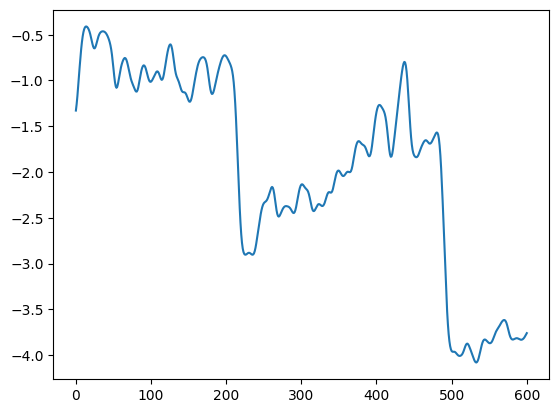

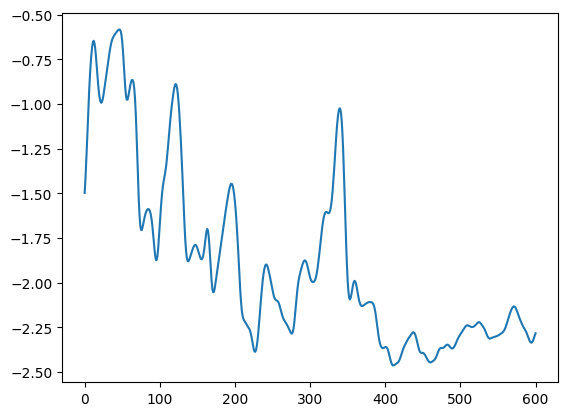

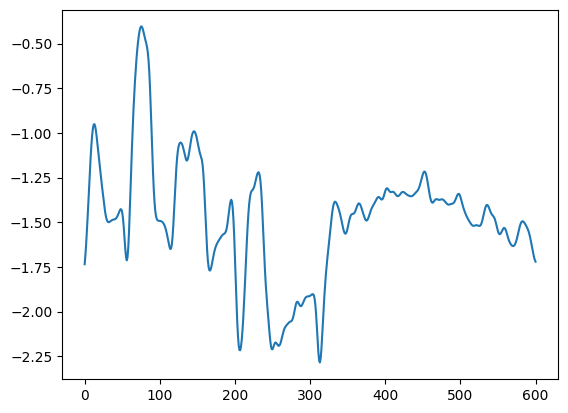

In [43]:
import scipy
pkl_path_succ = ['/home/dongyoon/FB_dataset/raw/low/one_leg/val/2023-12-07-21:42:00_success.pkl', '/home/dongyoon/FB_dataset/raw/low/one_leg/val/2023-12-07-21:43:25_success.pkl', '/home/dongyoon/FB_dataset/raw/low/one_leg/val/2023-12-07-21:48:56_success.pkl']
pkl_path_fail = ['/home/dongyoon/FB_dataset/raw/low/one_leg/val/2023-12-07-21:38:17_failure.pkl', '/home/dongyoon/FB_dataset/raw/low/one_leg/val/2023-12-07-21:39:20_failure.pkl', '/home/dongyoon/FB_dataset/raw/low/one_leg/val/2023-12-07-21:40:35_failure.pkl']

for pkl_path in pkl_path_fail:
    frames = pkl2frames(pkl_path)
    reward = extract_reward_100(frames, reward_model)
    reward_std = (reward - mean_reward) / std_reward
    reward_std = scipy.ndimage.gaussian_filter1d(reward_std, sigma=3,  mode="nearest")
    plt.figure()
    plt.plot(reward_std)
    plt.show()

In [ ]:
import cv2
import numpy as np
import imageio

for pkl_path in pkl_path_succ:
    frames = pkl2frames(pkl_path)
    video_name = pkl_path.split('/')[-1].split('.')[0]
    video_name = video_name + '.mp4'
    video_path = '/home/dongyoon/diffusion_reward/dongyoon' + '/' + video_name
    print(video_path)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' 또는 'XVID'
    video = cv2.VideoWriter(video_path, fourcc, 10, (64, 64)) 
    
    for i in range(frames.shape[0]):
        frame = frames[i].astype(np.uint8)  # float32에서 uint8으로 변환 (필요한 경우)
        cv2.putText(frame, f"Time: {i}", (3, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 255, 255), 1)
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    
    video.release()
    
    gif_path = '/home/dongyoon/diffusion_reward/dongyoon' + '/' + video_name.split('.')[0] + '.gif'
    reader = imageio.get_reader(video_path)
    fps = reader.get_meta_data()['fps']
    
    with imageio.get_writer(gif_path, duration=1000/fps) as writer:
        for frame in reader:
            writer.append_data(frame[:, :, :3])
            

/home/dongyoon/diffusion_reward/dongyoon/2023-12-07-21:42:00_success.mp4
/home/dongyoon/diffusion_reward/dongyoon/2023-12-07-21:43:25_success.mp4
/home/dongyoon/diffusion_reward/dongyoon/2023-12-07-21:48:56_success.mp4
